### High-Level Steps for Creating a Churn Prediction Model:

1. **Data Preprocessing**:
   - **Clean Data**: Ensure that the dataset is clean, with missing values handled appropriately.
   - **Feature Engineering**: Derive new features, if required
   - **Outlier Treatment**: Treat outliers in the dataset
      
2. **EDA**:
   - **Univariate Analysis**: Analyse the most important indicators wrt the churn probability
   - **Bivariate Analysis**: Analysis of churn rate by the decreasing usage variables in 7th and 8th Months
   - **Correlation Matrix**: Analysis Correlation between various features to get a sense of the data

3. **Final modifications to the features**:
   - **Categorical variables**: Convert features to categorical variables as needed 
   - **Train-Test Split**: Split the train data into train-test set in 70:30 ratio
   - **Data Scalling**: Scale the train and the test data. Fit tand transform the train data, transform the test data with the same scaler 
   - **Class Imbalance**: Handle class imbalance using SMOTE
   - **Principal Component Analysis (PCA)**: Apply PCA to reduce dimensionality and address multicollinearity among the selected features.
   
4. **Model Building**:
   - **Model Selection**: Choose a set of candidate models to train (e.g., Logistic Regression, Decision Tree, Random Forest, AdaBoost, XGBoost).
   - **Hyperparameter Tuning**:
     - Perform grid search or random search for hyperparameter tuning.
     - Use dynamic k-fold cross-validation to find the best value of `k` and tune hyperparameters.

5. **Model Evaluation and Selection**:
   - **Evaluate Models**: Assess models using metrics like accuracy, precision, recall, and F1-score.
   - **Compare Results**: Summarize and compare the performance of different models before and after applying PCA.
   -  **Model Selection**: Choose the best-performing model based on evaluation metrics and business objectives.

6. **Model Validation**:
   - **Cross-Validation**: Validate the selected model on unseen validation data to ensure its generalizability.

7. **Final Model Testing**:
   - **Test Data Prediction**: Apply the final model to the test data to make predictions.

Model Performance Summary:

                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.816810   0.337025  0.824766  0.478514
Decision Tree        0.839048   0.332613  0.575701  0.421629
Random Forest        0.898333   0.500946  0.618692  0.553627
AdaBoost             0.844714   0.374916  0.785047  0.507476

These steps provide a structured approach to building a robust churn prediction model, ensuring that you capture the most relevant features, optimize model performance, and validate the results.

**Recommendations**:

Based on the results, the Random Forest model performed the best, so we can use it to identify high-value customers likely to churn. Here are some recommendations:

Focus on Precision and Recall: Since our objective is to identify high-value customers who are likely to churn, we should focus on models that offer a good balance between precision and recall. The Random Forest model has a higher precision and a reasonable recall, meaning it's good at correctly identifying customers who are actually likely to churn.

Segment Customers by Usage Patterns: Utilize the derived variables indicating decreases in usage (e.g., decreased data usage, decreased recharge amounts) to segment customers. Those who show a significant decrease in their usage patterns might be flagged for retention efforts.

Proactive Retention Campaigns: Based on the identified high-risk customers, tailor proactive retention campaigns offering incentives like discounts, improved services, or personalized offers to retain these customers before they churn.

Monitor Churn Indicators: Continuously monitor the identified churn indicators and regularly update the model with new data to ensure that the predictions remain accurate over time.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from scipy import stats
from tabulate import tabulate
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from tabulate import tabulate

import warnings

In [2]:
# Setting max display columns and rows.
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings("ignore")


In [3]:
# Load the data
churn_data = pd.read_csv('train.csv')
churn_data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,Na

## 1. **Data Preprocessing**

In [4]:
# Let's summarise the data for creating an initial sense of the data quality
def metadata_matrix(data) : 
    return pd.DataFrame({
                'Datatype' : data.dtypes.astype(str), 
                'Non_Null_Count': data.count(axis = 0).astype(int), 
                'Null_Count': data.isnull().sum().astype(int), 
                'Null_Percentage': round(data.isnull().sum()/len(data) * 100 , 2), 
                'Unique_Values_Count': data.nunique().astype(int) 
                 }).sort_values(by='Null_Percentage', ascending=False)

metadata = metadata_matrix(churn_data)
print(metadata)

                         Datatype  Non_Null_Count  Null_Count  \
arpu_3g_6                 float64           17568       52431   
count_rech_2g_6           float64           17568       52431   
night_pck_user_6          float64           17568       52431   
arpu_2g_6                 float64           17568       52431   
date_of_last_rech_data_6   object           17568       52431   
total_rech_data_6         float64           17568       52431   
av_rech_amt_data_6        float64           17568       52431   
max_rech_data_6           float64           17568       52431   
count_rech_3g_6           float64           17568       52431   
fb_user_6                 float64           17568       52431   
night_pck_user_7          float64           17865       52134   
date_of_last_rech_data_7   object           17865       52134   
total_rech_data_7         float64           17865       52134   
max_rech_data_7           float64           17865       52134   
fb_user_7                

In [5]:
# Id is a unique identifier as it has all unique values and no nulls
# Setting Id as the index 
churn_data = churn_data.set_index('id')

### 1.1 Removing Columns that aren't required

Date Columns aren't required in our analysis. Let's delete them

In [6]:
# List the date columns
date_cols = [i for i in churn_data.columns.to_list() if 'date' in i]
print(date_cols) 

['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8']


In [7]:
# Dropping date columns
churn_data = churn_data.drop(date_cols, axis=1)

Let's find out the columns with only one unique value. These columns don't offer any insight and hence should be dropped

In [8]:
metadata = metadata_matrix(churn_data)
columns_to_drop_unique = metadata[metadata['Unique_Values_Count'] <= 1].index
print(columns_to_drop_unique) 

Index(['std_ic_t2o_mou_8', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6',
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_ic_t2o_mou_7',
       'loc_og_t2o_mou', 'loc_ic_t2o_mou', 'std_og_t2o_mou', 'circle_id'],
      dtype='object')


In [9]:
churn_data.drop(columns=columns_to_drop_unique, inplace=True)
metadata = metadata_matrix(churn_data)
print(metadata)

                   Datatype  Non_Null_Count  Null_Count  Null_Percentage  \
arpu_3g_6           float64           17568       52431            74.90   
night_pck_user_6    float64           17568       52431            74.90   
total_rech_data_6   float64           17568       52431            74.90   
count_rech_2g_6     float64           17568       52431            74.90   
count_rech_3g_6     float64           17568       52431            74.90   
fb_user_6           float64           17568       52431            74.90   
av_rech_amt_data_6  float64           17568       52431            74.90   
arpu_2g_6           float64           17568       52431            74.90   
max_rech_data_6     float64           17568       52431            74.90   
night_pck_user_7    float64           17865       52134            74.48   
fb_user_7           float64           17865       52134            74.48   
av_rech_amt_data_7  float64           17865       52134            74.48   
total_rech_d

In [10]:
# Columns with unique values < 34 can be considered as categorical variables. 
# The number 34 is arrived at, by looking at the above metadata_matrix output. 

columns=churn_data.columns
change_to_cat=[]
for column in columns:
    unique_value_count=churn_data[column].nunique()
    if unique_value_count <= 33 and unique_value_count != 0 and churn_data[column].dtype in ['int64','float64']:
        change_to_cat.append(column)
print( ' Columns to change to categorical data type : \n' ,pd.DataFrame(change_to_cat), '\n')

 Columns to change to categorical data type : 
                     0
0     count_rech_2g_6
1     count_rech_2g_7
2     count_rech_2g_8
3     count_rech_3g_6
4     count_rech_3g_7
5     count_rech_3g_8
6    night_pck_user_6
7    night_pck_user_7
8    night_pck_user_8
9        monthly_2g_6
10       monthly_2g_7
11       monthly_2g_8
12        sachet_2g_6
13        sachet_2g_7
14        sachet_2g_8
15       monthly_3g_6
16       monthly_3g_7
17       monthly_3g_8
18        sachet_3g_6
19        sachet_3g_7
20        sachet_3g_8
21          fb_user_6
22          fb_user_7
23          fb_user_8
24  churn_probability 



In [11]:
# Converting all the above columns having <=33 unique values into categorical data type.
churn_data[change_to_cat]=churn_data[change_to_cat].astype('category')

In [12]:
# Finding & Grouping categories with less than 1% contribution in each column into "Others"
categorical = churn_data.dtypes == 'category'
categorical_vars = churn_data.columns[categorical].to_list()
ind_categorical_vars = set(categorical_vars) - {'churn_probability'} #independent categorical variables
ind_categorical_vars

for col in ind_categorical_vars : 
    category_counts = 100*churn_data[col].value_counts(normalize=True)
    print('\n',tabulate(pd.DataFrame(category_counts), headers='keys', tablefmt='psql'),'\n')
    low_count_categories = category_counts[category_counts <= 1].index.to_list()
    print(f"Replaced {low_count_categories} in {col} with category : Others")
    churn_data[col].replace(low_count_categories,'Others',inplace=True)


 +----+--------------------+
|    |   night_pck_user_7 |
|----+--------------------|
|  0 |           97.5931  |
|  1 |            2.40694 |
+----+--------------------+ 

Replaced [] in night_pck_user_7 with category : Others

 +----+----------------+
|    |   monthly_3g_6 |
|----+----------------|
|  0 |    94.2728     |
|  1 |     4.50006    |
|  2 |     0.850012   |
|  3 |     0.238575   |
|  4 |     0.0842869  |
|  5 |     0.0228575  |
|  6 |     0.0142859  |
|  7 |     0.0114287  |
|  8 |     0.00285718 |
|  9 |     0.00285718 |
+----+----------------+ 

Replaced [2, 3, 4, 5, 6, 7, 8, 9] in monthly_3g_6 with category : Others

 +----+---------------+
|    |   sachet_3g_8 |
|----+---------------|
|  0 |   95.7999     |
|  1 |    2.8129     |
|  2 |    0.621437   |
|  3 |    0.270004   |
|  4 |    0.132859   |
|  5 |    0.108573   |
|  6 |    0.0514293  |
|  7 |    0.0442863  |
|  8 |    0.0357148  |
|  9 |    0.0228575  |
| 10 |    0.0185717  |
| 12 |    0.0142859  |
| 11 |    0.0


 +----+---------------+
|    |   sachet_2g_7 |
|----+---------------|
|  0 |   86.6827     |
|  1 |    5.21722    |
|  2 |    2.44718    |
|  3 |    1.36716    |
|  4 |    1.09573    |
|  5 |    0.800011   |
|  6 |    0.607152   |
|  7 |    0.438578   |
|  8 |    0.33429    |
| 10 |    0.254289   |
|  9 |    0.19286    |
| 11 |    0.168574   |
| 12 |    0.132859   |
| 14 |    0.0600009  |
| 13 |    0.0500007  |
| 15 |    0.038572   |
| 16 |    0.0185717  |
| 19 |    0.0157145  |
| 18 |    0.0142859  |
| 17 |    0.0114287  |
| 20 |    0.0100001  |
| 23 |    0.00857155 |
| 21 |    0.00714296 |
| 22 |    0.00714296 |
| 26 |    0.00428578 |
| 27 |    0.00428578 |
| 32 |    0.00285718 |
| 24 |    0.00142859 |
| 25 |    0.00142859 |
| 30 |    0.00142859 |
| 35 |    0.00142859 |
| 42 |    0.00142859 |
| 48 |    0.00142859 |
+----+---------------+ 

Replaced [5, 6, 7, 8, 10, 9, 11, 12, 14, 13, 15, 16, 19, 18, 17, 20, 23, 21, 22, 26, 27, 32, 24, 25, 30, 35, 42, 48] in sachet_2g_7 with category

### 1.2 Handeling missing values

In [13]:
# Intrestingly, either the columns have very high % of null values (> 70%) or very low % of null values (<6%)
# Hence, let's start by deleting the columns with high % of null values

# Filter columns with Null_Percentage greater than 70%
columns_to_drop = metadata[metadata['Null_Percentage'] > 70].index

# Drop these columns from the data
churn_data.drop(columns=columns_to_drop, inplace=True)

metadata_matrix(churn_data)

,Datatype,Non_Null_Count,Null_Count,Null_Percentage,Unique_Values_Count
loc_ic_t2f_mou_8,float64,66296,3703,5.29,6092
loc_og_t2t_mou_8,float64,66296,3703,5.29,11296
std_og_t2f_mou_8,float64,66296,3703,5.29,1945
isd_og_mou_8,float64,66296,3703,5.29,1008
spl_og_mou_8,float64,66296,3703,5.29,3848
std_og_t2m_mou_8,float64,66296,3703,5.29,15968
og_others_8,float64,66296,3703,5.29,179
std_og_t2t_mou_8,float64,66296,3703,5.29,14483
loc_ic_t2t_mou_8,float64,66296,3703,5.29,11446
loc_og_mou_8,float64,66296,3703,5.29,21950


In [14]:
churn_data.shape

(69999, 125)

Now let's handle the missing values in the columns
1. The missing value % in all the columns for a specific month is exactly the same. This simply means that the same rows have missing values for all the columns for a specific month
2. Also, all the missing values are related to incoming or outgoing calls. Data usage related columns aren't null. It might mean that the customers didn't use the connection for making or receiving calls. They used it simply for the data. let's figure out these type of customers who:
    a. Used internet but did not use IC (incoming) and OG (outgoing) services.
    b. Did not use internet, IC, or OG services.
    c. Used recharge services but did not use IC, OG, and internet services.

In [15]:
def find_customers_conditions(month):
    # Generate column names for the given month
    total_ic_mou_col = f'total_ic_mou_{month}'
    total_og_mou_col = f'total_og_mou_{month}'
    vol_2g_col = f'vol_2g_mb_{month}'
    vol_3g_col = f'vol_3g_mb_{month}'
    total_rech_amt_col = f'total_rech_amt_{month}'
    total_rech_num_col = f'total_rech_num_{month}'
    
    # Define conditions
    conditions = {
        'internet_only': ((churn_data[vol_2g_col] > 0) | (churn_data[vol_3g_col] > 0)) & 
                         (churn_data[total_ic_mou_col].isnull() | (churn_data[total_ic_mou_col] == 0)) & 
                         (churn_data[total_og_mou_col].isnull() | (churn_data[total_og_mou_col] == 0)),

        'no_usage': (churn_data[vol_2g_col].isnull() | (churn_data[vol_2g_col] == 0)) & 
                    (churn_data[vol_3g_col].isnull() | (churn_data[vol_3g_col] == 0)) & 
                    (churn_data[total_ic_mou_col].isnull() | (churn_data[total_ic_mou_col] == 0)) & 
                    (churn_data[total_og_mou_col].isnull() | (churn_data[total_og_mou_col] == 0)),

        'recharge_only': ((churn_data[total_rech_amt_col] > 0) | (churn_data[total_rech_num_col] > 0)) & 
                        (churn_data[vol_2g_col].isnull() | (churn_data[vol_2g_col] == 0)) & 
                        (churn_data[vol_3g_col].isnull() | (churn_data[vol_3g_col] == 0)) & 
                        (churn_data[total_ic_mou_col].isnull() | (churn_data[total_ic_mou_col] == 0)) & 
                        (churn_data[total_og_mou_col].isnull() | (churn_data[total_og_mou_col] == 0)),

        'no_recharge_no_usage': (churn_data[total_rech_amt_col].isnull() | (churn_data[total_rech_amt_col] == 0)) & 
                                (churn_data[total_rech_num_col].isnull() | (churn_data[total_rech_num_col] == 0)) & 
                                (churn_data[vol_2g_col].isnull() | (churn_data[vol_2g_col] == 0)) & 
                                (churn_data[vol_3g_col].isnull() | (churn_data[vol_3g_col] == 0)) & 
                                (churn_data[total_ic_mou_col].isnull() | (churn_data[total_ic_mou_col] == 0)) & 
                                (churn_data[total_og_mou_col].isnull() | (churn_data[total_og_mou_col] == 0))
    }
    
    return conditions
def print_summary(month, conditions):
    internet_only_count = churn_data[conditions['internet_only']].shape[0]
    no_usage_count = churn_data[conditions['no_usage']].shape[0]
    recharge_only_count = churn_data[conditions['recharge_only']].shape[0]
    no_recharge_no_usage_count = churn_data[conditions['no_recharge_no_usage']].shape[0]
    
    print(f"--- {month} Summary ---")
    print(f"Number of customers who used internet but not IC or OG services: {internet_only_count}")
    print(f"Number of customers who didn't use internet, IC, or OG services: {no_usage_count}")
    print(f"Number of customers who made recharges but didn't use internet, IC, or OG services: {recharge_only_count}")
    print(f"Number of customers who neither recharged nor used internet, IC, or OG services: {no_recharge_no_usage_count}")
    print("\n")


# Print the summary for each month using the dynamically generated conditions
for month in ['6', '7', '8']:
    conditions = find_customers_conditions(month)
    print_summary(f"Month {month}", conditions)


--- Month 6 Summary ---
Number of customers who used internet but not IC or OG services: 657
Number of customers who didn't use internet, IC, or OG services: 4731
Number of customers who made recharges but didn't use internet, IC, or OG services: 4086
Number of customers who neither recharged nor used internet, IC, or OG services: 645


--- Month 7 Summary ---
Number of customers who used internet but not IC or OG services: 631
Number of customers who didn't use internet, IC, or OG services: 4494
Number of customers who made recharges but didn't use internet, IC, or OG services: 3788
Number of customers who neither recharged nor used internet, IC, or OG services: 706


--- Month 8 Summary ---
Number of customers who used internet but not IC or OG services: 595
Number of customers who didn't use internet, IC, or OG services: 5490
Number of customers who made recharges but didn't use internet, IC, or OG services: 4088
Number of customers who neither recharged nor used internet, IC, or OG

Now let's try to find out if there are rows where total incoming and outgoing mou is not null but any of the other mou related columns are null. It's safe to update all mou related fields to 0 in such case

In [16]:
def find_ic_og_inconsistent_mou_rows(month):
    # Generate column names for the given month
    total_ic_mou_col = f'total_ic_mou_{month}'
    total_og_mou_col = f'total_og_mou_{month}'
    
    # Identify IC-related MOU columns for the given month (including additional fields)
    ic_mou_cols = [col for col in churn_data.columns if 
                   (col.startswith('loc_ic') or 
                    col.startswith('std_ic') or 
                    col.startswith('spl_ic') or 
                    col.startswith('isd_ic') or 
                    col.startswith('onnet_ic') or
                    col == f'ic_others_{month}' or 
                    col == f'roam_ic_mou_{month}' or
                    col == f'onnet_mou_{month}' or
                    col == f'offnet_mou_{month}') and col.endswith(f'_mou_{month}')]
    
    # Identify OG-related MOU columns for the given month (including additional fields)
    og_mou_cols = [col for col in churn_data.columns if 
                   (col.startswith('loc_og') or 
                    col.startswith('std_og') or 
                    col.startswith('spl_og') or 
                    col.startswith('isd_og') or 
                    col.startswith('onnet_og') or
                    col == f'og_others_{month}' or 
                    col == f'roam_og_mou_{month}' or
                    col == f'onnet_mou_{month}' or
                    col == f'offnet_mou_{month}') and col.endswith(f'_mou_{month}')]
    
    # Condition for IC inconsistency: total_ic_mou is not null, but any IC-related mou column is null
    ic_inconsistency_condition = churn_data[total_ic_mou_col].notnull() & churn_data[ic_mou_cols].isnull().any(axis=1)
    
    # Condition for OG inconsistency: total_og_mou is not null, but any OG-related mou column is null
    og_inconsistency_condition = churn_data[total_og_mou_col].notnull() & churn_data[og_mou_cols].isnull().any(axis=1)
    
    # Filter the DataFrame based on the conditions
    ic_inconsistent_rows = churn_data[ic_inconsistency_condition]
    og_inconsistent_rows = churn_data[og_inconsistency_condition]
    
    return ic_inconsistent_rows[ic_mou_cols + [total_ic_mou_col]], og_inconsistent_rows[og_mou_cols + [total_og_mou_col]]


In [17]:
def update_nulls_to_zero(month, ic_inconsistent_indices, og_inconsistent_indices):
    # Generate column names for the given month
    total_ic_mou_col = f'total_ic_mou_{month}'
    total_og_mou_col = f'total_og_mou_{month}'
    
    # Identify IC-related MOU columns for the given month (including additional fields)
    ic_mou_cols = [col for col in churn_data.columns if 
                   (col.startswith('loc_ic') or 
                    col.startswith('std_ic') or 
                    col.startswith('spl_ic') or 
                    col.startswith('isd_ic') or 
                    col.startswith('onnet_ic') or
                    col == f'ic_others_{month}' or 
                    col == f'roam_ic_mou_{month}' or
                    col == f'onnet_mou_{month}' or
                    col == f'offnet_mou_{month}') and col.endswith(f'_mou_{month}')]
    
    # Identify OG-related MOU columns for the given month (including additional fields)
    og_mou_cols = [col for col in churn_data.columns if 
                   (col.startswith('loc_og') or 
                    col.startswith('std_og') or 
                    col.startswith('spl_og') or 
                    col.startswith('isd_og') or 
                    col.startswith('onnet_og') or
                    col == f'og_others_{month}' or 
                    col == f'roam_og_mou_{month}' or
                    col == f'onnet_mou_{month}' or
                    col == f'offnet_mou_{month}') and col.endswith(f'_mou_{month}')]
    
    # Update IC-related nulls to 0, but only where the original column was null
    churn_data.loc[ic_inconsistent_indices, ic_mou_cols] = churn_data.loc[ic_inconsistent_indices, ic_mou_cols].fillna(0)
    
    # Update OG-related nulls to 0, but only where the original column was null
    churn_data.loc[og_inconsistent_indices, og_mou_cols] = churn_data.loc[og_inconsistent_indices, og_mou_cols].fillna(0)
    
    print(f"--- Month {month}: Updated null values to 0 for IC and OG MOU fields where inconsistencies were found. ---")

# Apply updates for each month
for month in ['6', '7', '8']:
    ic_inconsistent_rows, og_inconsistent_rows = find_ic_og_inconsistent_mou_rows(month)
    update_nulls_to_zero(month, ic_inconsistent_rows.index, og_inconsistent_rows.index)


--- Month 6: Updated null values to 0 for IC and OG MOU fields where inconsistencies were found. ---
--- Month 7: Updated null values to 0 for IC and OG MOU fields where inconsistencies were found. ---
--- Month 8: Updated null values to 0 for IC and OG MOU fields where inconsistencies were found. ---


In [18]:
metadata = metadata_matrix(churn_data)
print(metadata)

                    Datatype  Non_Null_Count  Null_Count  Null_Percentage  \
og_others_8          float64           66296        3703             5.29   
ic_others_8          float64           66296        3703             5.29   
og_others_6          float64           67231        2768             3.95   
ic_others_6          float64           67231        2768             3.95   
og_others_7          float64           67312        2687             3.84   
ic_others_7          float64           67312        2687             3.84   
spl_ic_mou_8         float64           69999           0             0.00   
total_ic_mou_8       float64           69999           0             0.00   
spl_ic_mou_6         float64           69999           0             0.00   
spl_ic_mou_7         float64           69999           0             0.00   
isd_ic_mou_7         float64           69999           0             0.00   
isd_ic_mou_6         float64           69999           0             0.00   

All other MOU related fields fullfilled the critiera. That is, the fields had null values for the rows where total MOU value were not null. We did this operation seperatelly for IC and OG.
We've included ic_others and og_others field in the above code but somehow for these two fields, it isn't working. Let's update just these two fields for all three months for the rows where total mou isn't null for IC as well as OG

In [19]:
def find_and_print_before_update(month):
    total_ic_mou_col = f'total_ic_mou_{month}'
    ic_others_col = f'ic_others_{month}'
    total_og_mou_col = f'total_og_mou_{month}'
    og_others_col = f'og_others_{month}'
    
    # Condition to identify rows where total IC is not null and ic_others is null
    ic_condition = churn_data[total_ic_mou_col].notnull() & churn_data[ic_others_col].isnull()
    og_condition = churn_data[total_og_mou_col].notnull() & churn_data[og_others_col].isnull()
    
    print(f"--- Month {month}: Rows before updating IC others to 0 ---")
    print(churn_data.loc[ic_condition, [total_ic_mou_col, ic_others_col]].head())
    
    print(f"--- Month {month}: Rows before updating OG others to 0 ---")
    print(churn_data.loc[og_condition, [total_og_mou_col, og_others_col]].head())
    
    return ic_condition, og_condition

# Apply this check for each month
for month in ['6', '7', '8']:
    ic_cond, og_cond = find_and_print_before_update(month)

    
def reapply_update_to_zero(month, ic_condition, og_condition):
    # Identify columns to update
    ic_others_col = f'ic_others_{month}'
    og_others_col = f'og_others_{month}'
    
    # Apply the update
    churn_data.loc[ic_condition, ic_others_col] = churn_data.loc[ic_condition, ic_others_col].fillna(0)
    churn_data.loc[og_condition, og_others_col] = churn_data.loc[og_condition, og_others_col].fillna(0)
    
    print(f"--- Month {month}: Reapplied update to zero for IC and OG others columns ---")

# Reapply the update and check the results
for month in ['6', '7', '8']:
    ic_cond, og_cond = find_and_print_before_update(month)  # Identify conditions
    reapply_update_to_zero(month, ic_cond, og_cond)          # Apply update

def verify_update(month):
    ic_others_col = f'ic_others_{month}'
    og_others_col = f'og_others_{month}'
    
    # Check if any NaNs remain after the update
    ic_nulls = churn_data[ic_others_col].isnull().sum()
    og_nulls = churn_data[og_others_col].isnull().sum()
    
    print(f"--- Month {month}: NaN count in IC others after update: {ic_nulls} ---")
    print(f"--- Month {month}: NaN count in OG others after update: {og_nulls} ---")

# Verify the update for each month
for month in ['6', '7', '8']:
    verify_update(month)



--- Month 6: Rows before updating IC others to 0 ---
     total_ic_mou_6  ic_others_6
id                              
26              0.0          NaN
33              0.0          NaN
95              0.0          NaN
101             0.0          NaN
135             0.0          NaN
--- Month 6: Rows before updating OG others to 0 ---
     total_og_mou_6  og_others_6
id                              
26              0.0          NaN
33              0.0          NaN
95              0.0          NaN
101             0.0          NaN
135             0.0          NaN
--- Month 7: Rows before updating IC others to 0 ---
     total_ic_mou_7  ic_others_7
id                              
33              0.0          NaN
37              0.0          NaN
54              0.0          NaN
59              0.0          NaN
101             0.0          NaN
--- Month 7: Rows before updating OG others to 0 ---
     total_og_mou_7  og_others_7
id                              
33              0.0          

In [20]:
# Let's check the data now

metadata = metadata_matrix(churn_data)
print(metadata)

                    Datatype  Non_Null_Count  Null_Count  Null_Percentage  \
arpu_6               float64           69999           0              0.0   
total_ic_mou_7       float64           69999           0              0.0   
total_rech_num_8       int64           69999           0              0.0   
total_rech_num_7       int64           69999           0              0.0   
total_rech_num_6       int64           69999           0              0.0   
ic_others_8          float64           69999           0              0.0   
ic_others_7          float64           69999           0              0.0   
ic_others_6          float64           69999           0              0.0   
isd_ic_mou_8         float64           69999           0              0.0   
isd_ic_mou_7         float64           69999           0              0.0   
isd_ic_mou_6         float64           69999           0              0.0   
spl_ic_mou_8         float64           69999           0              0.0   

Looks like all the null values are gone. Let's move forward.

## 1.3 Outlier Treatment

In [21]:
churn_data.shape

(69999, 125)

In [22]:
#Let's convert the churn probability field into object type and treat rest all numerical columns for outliers

churn_data['churn_probability'] = churn_data['churn_probability'].astype(object)

In [23]:
# List only the numeric columns
numeric_cols = churn_data.select_dtypes(include=['int64', 'float64']).columns
print(numeric_cols)

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'roam_ic_mou_6',
       ...
       'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6',
       'vol_3g_mb_7', 'vol_3g_mb_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=112)


In [24]:
churn_data.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.8, 0.85, 0.9])

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
count,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.00000
mean,283.134365,278.185912,278.858826,127.887939,128.754731,125.943607,191.010582,189.585401,186.146273,9.379276,6.745305,6.634328,13.625476,9.464386,9.254848,45.050076,44.394344,43.269280,89.551272,87.313796,86.301054,3.595161,3.632045,3.467948,1.081499,1.308807,1.345676,138.203540,135.347249,133.045174,77.431415,80.560009,79.055781,84.666274,88.024790,85.794878,1.081836,1.042449,1.001784,163.182149,169.629833,165.854932,0.812319,0.779964,0.797125,3.802082,4.785743,4.778142,0.444289,0.023487,0.031310,306.451436,310.572674,304.513065,46.143461,46.044697,44.756489,102.915265,102.402108,102.433264,11.574147,12.081392,11.096938,160.641286,160.536704,158.295100,9.102206,9.494462,9.385959,19.914931,20.852939,19.973415,2.061402,2.114968,1.965401,31.080982,32.464858,31.327231,199.710640,201.878029,198.486034,0.059483,0.032090,0.038255,7.101776,7.857501,7.906786,0.820291,0.980539,0.912259,7.566522,7.706

filtered_data = churn_data.copy()

for col in numeric_cols: 
    q1 = filtered_data[col].quantile(0.10)
    q3 = filtered_data[col].quantile(0.99)
    iqr = q3 - q1
    range_low  = q1 - 1 * iqr
    range_high = q3 + 1 * iqr
    
    # Filter rows only for this column, do not update the DataFrame iteratively
    filtered_data = filtered_data[(filtered_data[col] > range_low) & (filtered_data[col] < range_high)]

print(filtered_data.shape)



In [25]:
# Looking at quantiles from 0.90 to 1. 
churn_data.quantile(np.arange(0.9,1.01,0.01)).style.bar()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0.900000,619.993800,615.661400,614.994600,331.766000,334.886000,326.298000,468.898000,470.054000,467.636000,10.890000,4.392000,4.280000,20.864000,8.560000,7.552000,101.114000,98.110000,97.230000,227.686000,221.760000,223.132000,9.130000,9.164000,8.730000,2.252000,2.810000,3.110000,346.314000,337.130000,335.660000,204.840000,212.976000,209.376000,226.130000,236.964000,232.998000,0.550000,0.330000,0.300000,511.176000,537.254000,526.412000,0.000000,0.000000,0.000000,10.230000,12.530000,12.910000,1.180000,0.000000,0.000000,785.230000,806.250000,792.858000,104.294000,102.848000,100.914000,248.382000,246.194000,247.110000,28.844000,29.180000,26.944000,383.174000,379.632000,377.030000,19.080000,19.660000,19.030000,45.810000,47.840000,46.286000,2.500000,2.560000,2.502000,73.030000,75.482000,73.030000,467.030000,468.524000,464.508000,0.260000,0.050000,0.100000,4.130000,5.780000,5.280000,0.560000,0.710000,0.680000,15.000000,15.000000,15.000000,735.000000,730.000000,734.000000,200.000000,200.000000,225.000000,128.000000,130.000000,150.000000,103.514000,97.410000,93.290000,302.810000,335.372000,372.540000,2792.000000,160.444000,136.272000,110.328000
0.910000,650.812760,646.384060,647.270680,366.043600,370.758000,361.430000,501.235400,504.731800,502.947200,13.680000,6.131800,6.130000,26.031800,12.351800,11.110000,110.330000,106.781800,105.465400,243.922600,238.193600,238.763600,10.213600,10.340000,9.830000,2.750000,3.430000,3.710000,370.190000,362.693600,359.689000,236.802600,246.894400,242.685400,255.319000,267.972600,265.274400,0.880000,0.700000,0.630000,561.222600,588.994400,579.272600,0.000000,0.000000,0.000000,11.380000,13.930000,14.281800,1.400000,0.000000,0.000000,839.199000,859.606200,847.697200,112.431800,111.160000,109.063600,264.689000,262.180000,262.963600,32.113600,32.690000,30.360000,408.199000,401.544400,401.230000,21.480000,22.410000,21.710000,50.893600,53.160000,51.463600,3.091800,3.163600,3.040000,80.143600,82.543600,80.480000,496.790800,498.322600,492.697200,0.280000,0.080000,0.150000,6.213600,8.010000,7.580000,0.700000,0.881800,0.830000,16.000000,16.000000,16.000000,770.000000,766.000000,766.000000,250.000000,250.000000,250.000000,150.000000,150.000000,150.000000,128.463600,123.040000,116.851800,388.584400,415.093600,457.582400,2861.180000,204.255400,179.829000,149.735400
0.920000,687.932720,682.805120,681.293120,409.164

In [26]:
# Looking at percentage change in quantiles from 0.90 to 1. 
churn_data.quantile(np.arange(0.9,1.01,0.01)).pct_change().mul(100).style.bar()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0.900000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
0.910000,4.970850,4.990188,5.248189,10.331860,10.711705,10.766845,6.896468,7.377408,7.551001,25.619835,39.612933,43.224299,24.768980,44.296729,47.113347,9.114465,8.838854,8.470020,7.131137,7.410534,7.005539,11.868565,12.832824,12.600229,22.113677,22.064057,19.292605,6.894321,7.582713,7.158732,15.603691,15.925926,15.908891,12.908062,13.085785,13.852651,60.000000,112.121212,110.000000,9.790483,9.630529,10.041678,nan,nan,nan,11.241447,11.173184,10.625871,18.644068,nan,nan,6.873018,6.617823,6.916648,7.802750,8.081829,8.075787,6.565291,6.493253,6.415604,11.335460,12.028787,12.678147,6.530975,5.772011,6.418587,12.578616,13.987792,14.083027,11.097140,11.120401,11.186104,23.672000,23.578125,21.502798,9.740655,9.355343,10.201287,6.372353,6.360101,6.068615,7.692308,60.000000,50.000000,50.450363,38.581315,43.560606,25.000000,24.197183,22.058824,6.666667,6.666667,6.666667,4.761905,4.931507,4.359673,25.000000,25.000000,11.111111,17.187500,15.384615,0.000000,24.102633,26.311467,25.256512,28.326145,23.771096,22.827723,2.477794,27.306350,31.963279,35.718403
0.920000,5.703631,5.634585,5.256292,11.780345,12.353071,12.245801,7.704763,8.368048,8.006964,28.593567,40.415539,39.367047,26.632811,35.283926,39.348335,9.611892,9.926598,9.906377,7.853885,7.719771,7.845752,13.671967,13.442940,14.038657,24.000000,21.282799,19.946092,8.151166,8.575944,7.819033,16.836217,16.742867,16.398267,13.145359,13.481005,13.095421,54.545455,64.285714,66.666667,10.490205,10.190861,9.855843,nan,nan,nan,11.876977,10.923187,11.190466,15.000000,nan,nan,7.307230,7.330682,7.194880,9.559751,9.213026,9.287792,7.326561,6.617591,7.168749,12.195456,12.363414,12.587615,6.928630,7.532318,6.998480,14.439479,13.609996,14.187011,11.723282,11.136193,11.269324,23.876059,23.593375,23.407895,10.220654,11.593388,10.623757,7.106009,6.412834,6.684187,7.142857,62.500000,40.000000,42.133385,37.328340,39.841689,25.714286,28.146972,24.096386,6.25000

In [27]:
# Columns with outliers 
pct_change_99_1 = churn_data.quantile(np.arange(0.9,1.01,0.01)).pct_change().mul(100).iloc[-1]
outlier_condition = pct_change_99_1 > 100
columns_with_outliers = pct_change_99_1[outlier_condition].index.values
print('Columns with outliers :\n', columns_with_outliers)

Columns with outliers :
 ['arpu_6' 'arpu_7' 'arpu_8' 'onnet_mou_6' 'onnet_mou_7' 'onnet_mou_8'
 'offnet_mou_6' 'offnet_mou_7' 'offnet_mou_8' 'roam_ic_mou_6'
 'roam_ic_mou_7' 'roam_ic_mou_8' 'roam_og_mou_6' 'roam_og_mou_7'
 'roam_og_mou_8' 'loc_og_t2t_mou_6' 'loc_og_t2t_mou_7' 'loc_og_t2t_mou_8'
 'loc_og_t2m_mou_6' 'loc_og_t2m_mou_7' 'loc_og_t2m_mou_8'
 'loc_og_t2f_mou_6' 'loc_og_t2f_mou_7' 'loc_og_t2f_mou_8'
 'loc_og_t2c_mou_6' 'loc_og_t2c_mou_7' 'loc_og_t2c_mou_8' 'loc_og_mou_6'
 'loc_og_mou_7' 'loc_og_mou_8' 'std_og_t2t_mou_6' 'std_og_t2t_mou_7'
 'std_og_t2t_mou_8' 'std_og_t2m_mou_6' 'std_og_t2m_mou_7'
 'std_og_t2m_mou_8' 'std_og_t2f_mou_6' 'std_og_t2f_mou_7'
 'std_og_t2f_mou_8' 'std_og_mou_6' 'std_og_mou_7' 'std_og_mou_8'
 'isd_og_mou_6' 'isd_og_mou_7' 'isd_og_mou_8' 'spl_og_mou_6'
 'spl_og_mou_7' 'spl_og_mou_8' 'og_others_6' 'og_others_7' 'og_others_8'
 'total_og_mou_6' 'total_og_mou_7' 'total_og_mou_8' 'loc_ic_t2t_mou_6'
 'loc_ic_t2t_mou_7' 'loc_ic_t2t_mou_8' 'loc_ic_t2m_mou_6'
 '

In [28]:
# capping outliers to 99th percentile values
outlier_treatment = pd.DataFrame(columns=['Column', 'Outlier Threshold', 'Outliers replaced'])
for col in columns_with_outliers : 
    outlier_threshold = churn_data[col].quantile(0.99)
    condition = churn_data[col] > outlier_threshold
    outlier_treatment = outlier_treatment.append({'Column' : col , 'Outlier Threshold' : outlier_threshold, 'Outliers replaced' : churn_data.loc[condition,col].shape[0] }, ignore_index=True)
    churn_data.loc[condition, col] = outlier_threshold
outlier_treatment

,Column,Outlier Threshold,Outliers replaced
0,arpu_6,1400.27664,700
1,arpu_7,1414.89138,700
2,arpu_8,1445.05480,700
3,onnet_mou_6,1429.04040,700
4,onnet_mou_7,1461.34220,700
5,onnet_mou_8,1448.89100,700
6,offnet_mou_6,1520.31000,699
7,offnet_mou_7,1517.83860,700
8,offnet_mou_8,1492.23240,700
9,roam_ic_mou_6,213.82740,700


In [29]:
churn_data.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.8, 0.85, 0.9])

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
count,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.0,69999.0,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,276.801400,271.750628,272.279495,120.747130,121.224215,118.333505,184.197691,182.341078,178.947790,7.202796,4.419804,4.423778,10.896800,7.125063,6.778140,39.08501,38.080647,37.396778,85.687874,83.868377,83.065043,3.158193,3.191669,3.054412,0.891776,1.063363,1.125445,131.824119,129.198780,127.151874,71.140241,74.026443,72.375457,78.101083,80.848631,78.581470,0.751818,0.698311,0.671219,155.508645,161.067132,157.342823,0.132915,0.131065,0.102718,3.294120,4.102357,4.181816,0.365163,0.0,0.0,298.076587,301.513103,295.369724,40.516020,40.125225,39.208114,98.571116,98.214771,98.550206,10.278059,10.596124,9.815132,154.281962,154.093757,152.427265,7.073024,7.394241,7.254519,16.762632,17.450953,16.951755,1.407978,1.453137,1.356903,27.19583,28.332416,27.407136,193.049313,194.826829,191.982339,0.058085,0.029775,0.036656,4.653852,5.086547,5.141708,0.435802,0.510023,0.478787,7.450964,7.590294,7.109930,320.292361,314

## 1.4 Derive new features

In the end, let's derive some new features. Let's figure out the decrease in acivity for a customer from 6th to 7th anf from 7th to 8th month.

In [30]:
# Total Voice Usage: Combine total incoming and outgoing minutes of usage
churn_data['total_voice_mou_6'] = churn_data['total_ic_mou_6'] + churn_data['total_og_mou_6']
churn_data['total_voice_mou_7'] = churn_data['total_ic_mou_7'] + churn_data['total_og_mou_7']
churn_data['total_voice_mou_8'] = churn_data['total_ic_mou_8'] + churn_data['total_og_mou_8']

# Total Internet Usage (combining 2G and 3G churn_data volumes)
churn_data['total_data_usage_6'] = churn_data['vol_2g_mb_6'] + churn_data['vol_3g_mb_6']
churn_data['total_data_usage_7'] = churn_data['vol_2g_mb_7'] + churn_data['vol_3g_mb_7']
churn_data['total_data_usage_8'] = churn_data['vol_2g_mb_8'] + churn_data['vol_3g_mb_8']

# Binary flags indicating whether the usage/value decreased
# For voice usage
churn_data['decreased_voice_mou_6_7'] = (churn_data['total_voice_mou_6'] > churn_data['total_voice_mou_7']).astype(int)
churn_data['decreased_voice_mou_7_8'] = (churn_data['total_voice_mou_7'] > churn_data['total_voice_mou_8']).astype(int)

# For internet usage
churn_data['decreased_data_usage_6_7'] = (churn_data['total_data_usage_6'] > churn_data['total_data_usage_7']).astype(int)
churn_data['decreased_data_usage_7_8'] = (churn_data['total_data_usage_7'] > churn_data['total_data_usage_8']).astype(int)

# For recharge amount
churn_data['decreased_rech_amt_6_7'] = (churn_data['total_rech_amt_6'] > churn_data['total_rech_amt_7']).astype(int)
churn_data['decreased_rech_amt_7_8'] = (churn_data['total_rech_amt_7'] > churn_data['total_rech_amt_8']).astype(int)

# For number of recharges
churn_data['decreased_rech_num_6_7'] = (churn_data['total_rech_num_6'] > churn_data['total_rech_num_7']).astype(int)
churn_data['decreased_rech_num_7_8'] = (churn_data['total_rech_num_7'] > churn_data['total_rech_num_8']).astype(int)

# For Volume based cost
churn_data['decreased_vbc_3g_6_7'] = (churn_data['jun_vbc_3g'] > churn_data['jul_vbc_3g']).astype(int)
churn_data['decreased_vbc_3g_7_8'] = (churn_data['jul_vbc_3g'] > churn_data['aug_vbc_3g']).astype(int)

# Display the newly created columns to verify
print(churn_data[['decreased_voice_mou_6_7', 'decreased_voice_mou_7_8',
            'decreased_data_usage_6_7', 'decreased_data_usage_7_8',
            'decreased_rech_amt_6_7', 'decreased_rech_amt_7_8',
            'decreased_rech_num_6_7', 'decreased_rech_num_7_8',
            'decreased_vbc_3g_6_7', 'decreased_vbc_3g_7_8']].head())


    decreased_voice_mou_6_7  decreased_voice_mou_7_8  \
id                                                     
0                         0                        1   
1                         0                        1   
2                         1                        1   
3                         1                        1   
4                         1                        1   

    decreased_data_usage_6_7  decreased_data_usage_7_8  \
id                                                       
0                          0                         0   
1                          0                         1   
2                          0                         0   
3                          0                         0   
4                          1                         1   

    decreased_rech_amt_6_7  decreased_rech_amt_7_8  decreased_rech_num_6_7  \
id                                                                           
0                        1                  


## 2. **EDA**

### 2.1 Univariate analysis

Churn rate on the basis whether the customer decreased her/his MOU in action month

In [31]:
# Converting churn column to int in order to do aggfunc in the pivot table
churn_data['churn_probability'] = churn_data['churn_probability'].astype('int64')

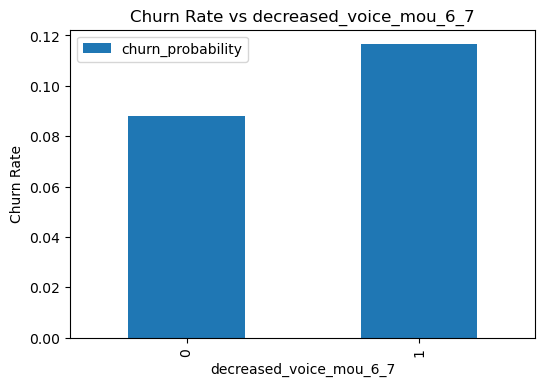

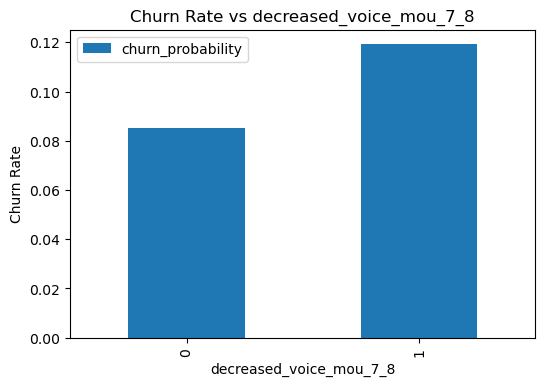

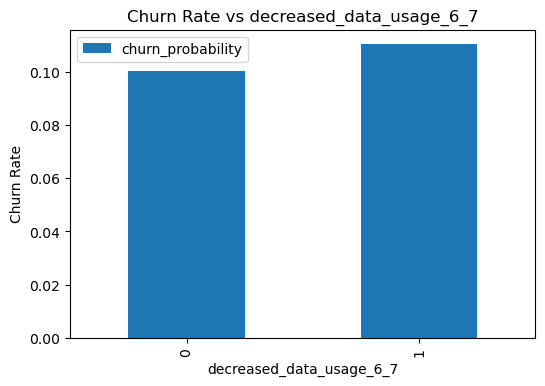

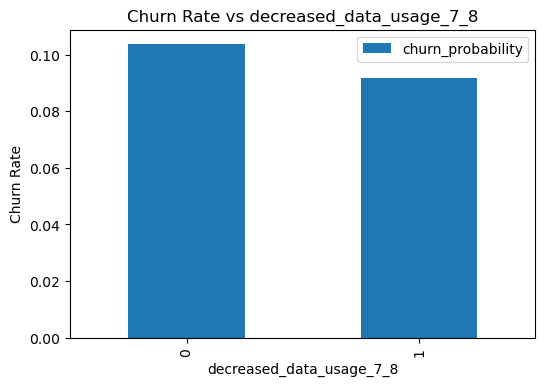

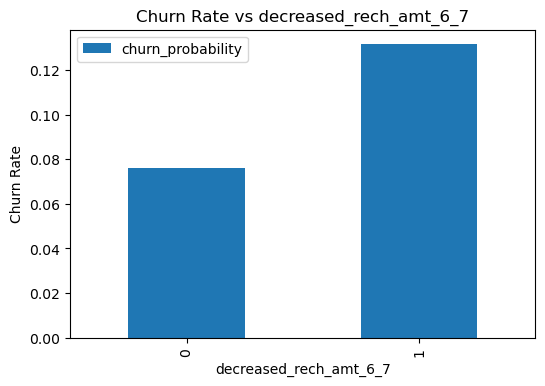

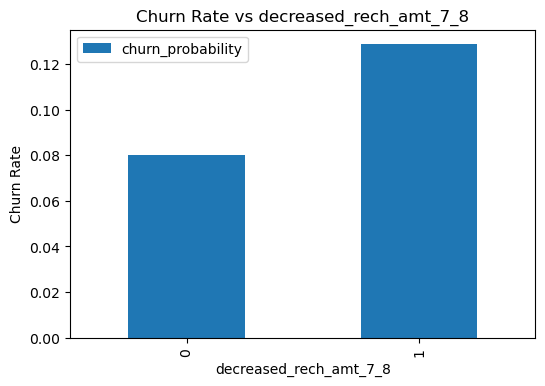

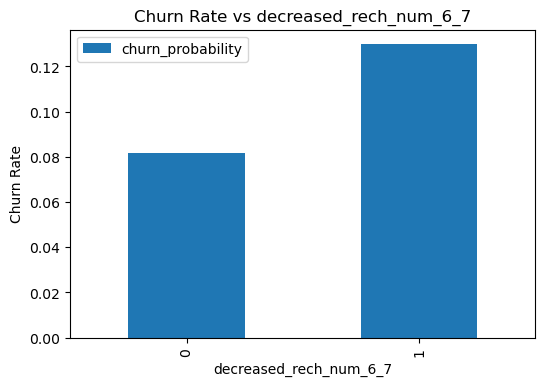

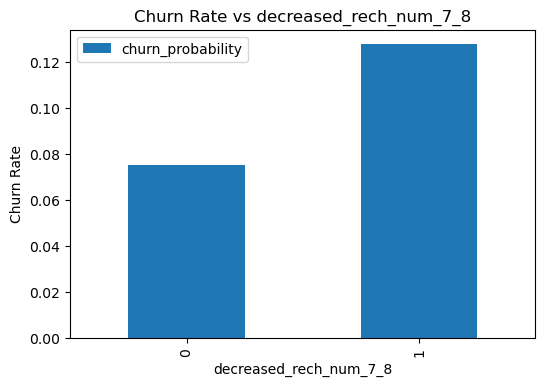

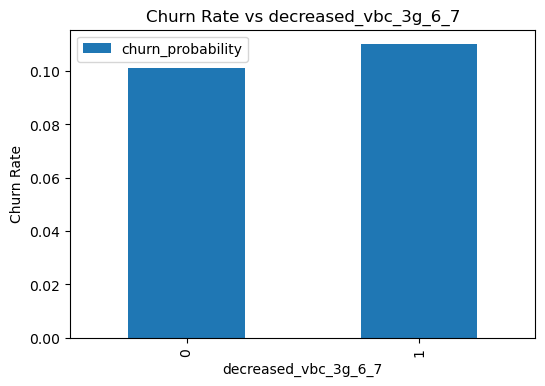

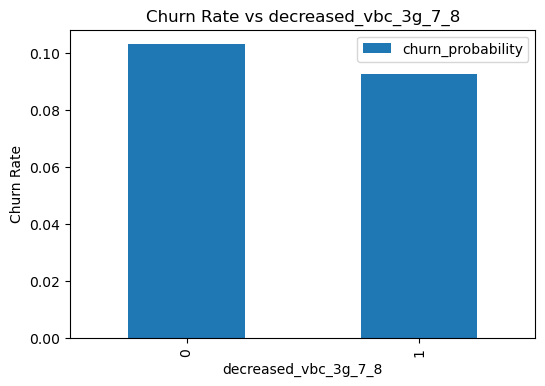

In [32]:
# List of derived "decreased" columns to plot against churn_probability
decreased_columns = [
    'decreased_voice_mou_6_7', 'decreased_voice_mou_7_8',
    'decreased_data_usage_6_7', 'decreased_data_usage_7_8',
    'decreased_rech_amt_6_7', 'decreased_rech_amt_7_8',
    'decreased_rech_num_6_7', 'decreased_rech_num_7_8',
    'decreased_vbc_3g_6_7', 'decreased_vbc_3g_7_8'
]

# Generate bar plots for each "decreased" column against churn_probability
for col in decreased_columns:
    pivot_table = churn_data.pivot_table(values='churn_probability', index=col, aggfunc='mean')
    pivot_table.plot.bar(figsize=(6, 4))  # Set the figure size directly in plot.bar()
    plt.ylabel('Churn Rate')
    plt.title(f'Churn Rate vs {col}')
    plt.show()


**Analysis:** We can see that the lesser no and amount of recharges means higher probability of Churn

Analysis of the average revenue per customer (churn and not churn) in the action phase

In [33]:
# Creating churn dataframe
data_churn = churn_data[churn_data['churn_probability'] == 1]
# Creating not churn dataframe
data_non_churn = churn_data[churn_data['churn_probability'] == 0]

[Text(0.5, 0, 'ARPU in Month 6')]

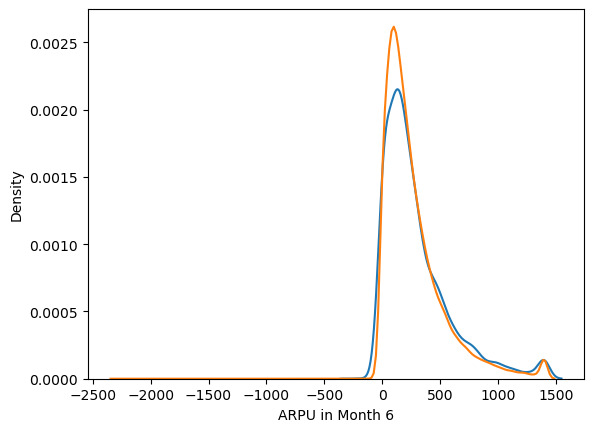

In [34]:
# Distribution plot
ax = sns.distplot(data_churn['arpu_6'],label='Churn',hist=False)
ax = sns.distplot(data_non_churn['arpu_6'],label='Not Churn',hist=False)
ax.set(xlabel='ARPU in Month 6')

[Text(0.5, 0, 'ARPU in Month 7')]

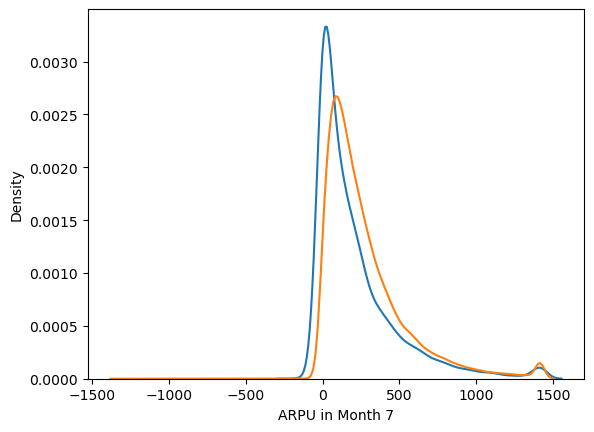

In [35]:
# Distribution plot
ax = sns.distplot(data_churn['arpu_7'],label='Churn',hist=False)
ax = sns.distplot(data_non_churn['arpu_7'],label='Not Churn',hist=False)
ax.set(xlabel='ARPU in Month 7')

[Text(0.5, 0, 'ARPU in Month 8')]

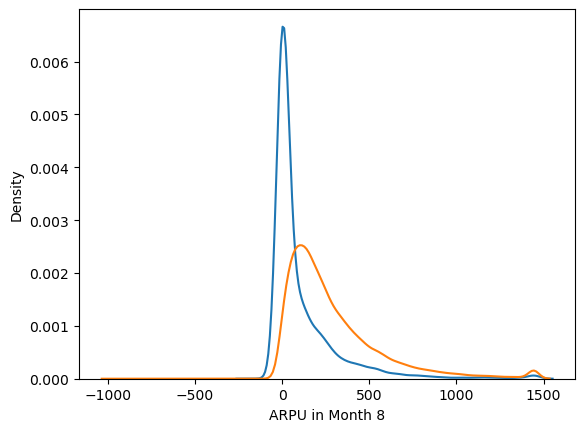

In [36]:
# Distribution plot
ax = sns.distplot(data_churn['arpu_8'],label='Churn',hist=False)
ax = sns.distplot(data_non_churn['arpu_8'],label='Not Churn',hist=False)
ax.set(xlabel='ARPU in Month 8')

**Analysis:** Visible decrease in ARPU for the customers with higher churn probability

### 2.2 Bivariate analysis

Analysis of churn rate by the decreasing usage variables in 7th and 8th Months

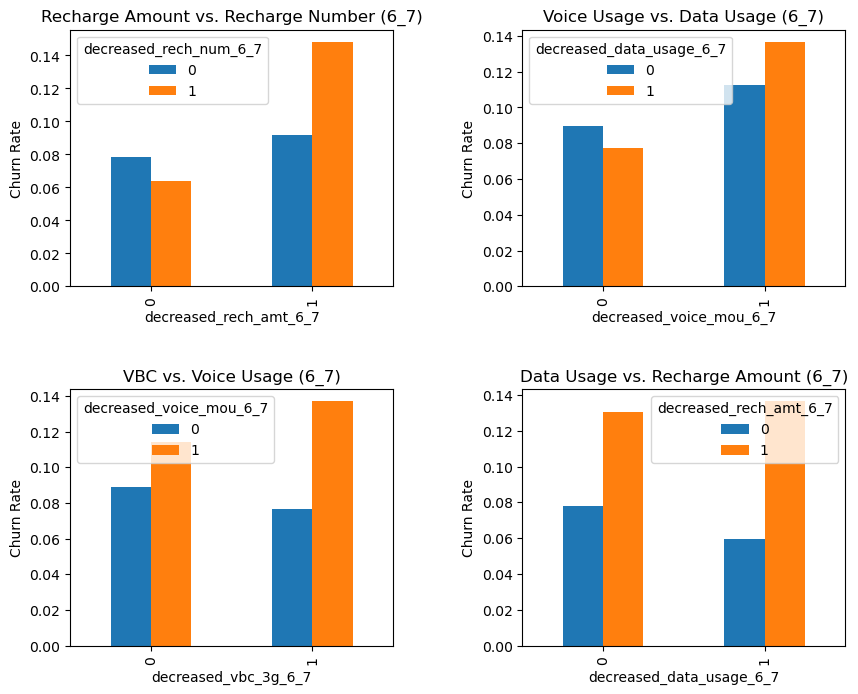

Text(0.5, 1.0, 'Data Usage vs. Recharge Amount (7_8)')

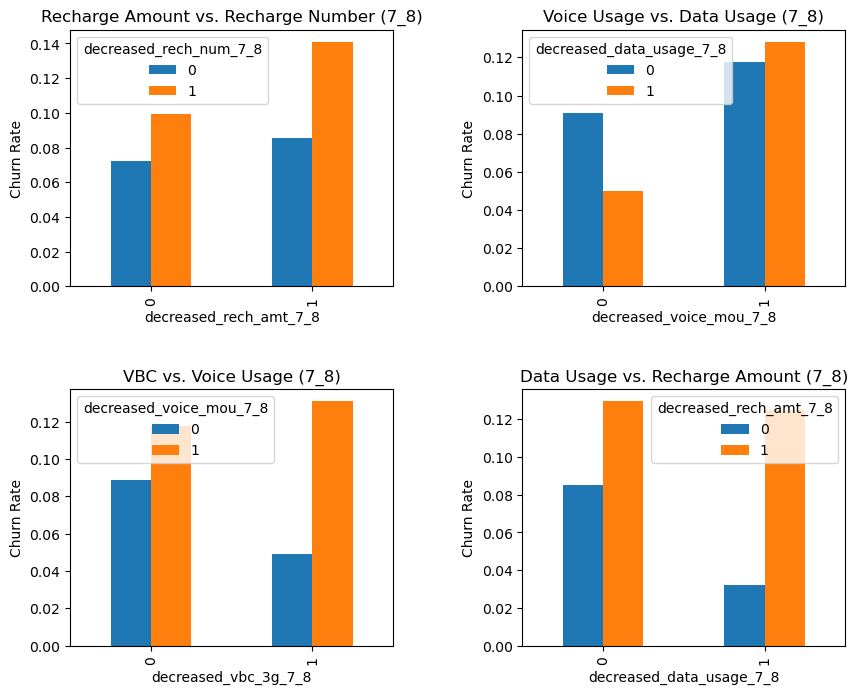

In [37]:
# Create a figure with subplots for 6_7 variables
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Plot 1: Churn rate based on decreased recharge amount and decreased recharge number (Month 6 to 7)
churn_data.pivot_table(values='churn_probability', index='decreased_rech_amt_6_7', columns='decreased_rech_num_6_7', aggfunc='mean').plot.bar(ax=axes[0, 0])
axes[0, 0].set_ylabel('Churn Rate')
axes[0, 0].set_title('Recharge Amount vs. Recharge Number (6_7)')

# Plot 2: Churn rate based on decreased voice usage and decreased data usage (Month 6 to 7)
churn_data.pivot_table(values='churn_probability', index='decreased_voice_mou_6_7', columns='decreased_data_usage_6_7', aggfunc='mean').plot.bar(ax=axes[0, 1])
axes[0, 1].set_ylabel('Churn Rate')
axes[0, 1].set_title('Voice Usage vs. Data Usage (6_7)')

# Plot 3: Churn rate based on decreased volume-based cost and decreased voice usage (Month 6 to 7)
churn_data.pivot_table(values='churn_probability', index='decreased_vbc_3g_6_7', columns='decreased_voice_mou_6_7', aggfunc='mean').plot.bar(ax=axes[1, 0])
axes[1, 0].set_ylabel('Churn Rate')
axes[1, 0].set_title('VBC vs. Voice Usage (6_7)')

# Plot 4: Churn rate based on decreased data usage and decreased recharge amount (Month 6 to 7)
churn_data.pivot_table(values='churn_probability', index='decreased_data_usage_6_7', columns='decreased_rech_amt_6_7', aggfunc='mean').plot.bar(ax=axes[1, 1])
axes[1, 1].set_ylabel('Churn Rate')
axes[1, 1].set_title('Data Usage vs. Recharge Amount (6_7)')

# Show all plots for 6_7 variables
plt.show()

# Create a new figure with subplots for 7_8 variables
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Plot 1: Churn rate based on decreased recharge amount and decreased recharge number (Month 7 to 8)
churn_data.pivot_table(values='churn_probability', index='decreased_rech_amt_7_8', columns='decreased_rech_num_7_8', aggfunc='mean').plot.bar(ax=axes[0, 0])
axes[0, 0].set_ylabel('Churn Rate')
axes[0, 0].set_title('Recharge Amount vs. Recharge Number (7_8)')

# Plot 2: Churn rate based on decreased voice usage and decreased data usage (Month 7 to 8)
churn_data.pivot_table(values='churn_probability', index='decreased_voice_mou_7_8', columns='decreased_data_usage_7_8', aggfunc='mean').plot.bar(ax=axes[0, 1])
axes[0, 1].set_ylabel('Churn Rate')
axes[0, 1].set_title('Voice Usage vs. Data Usage (7_8)')

# Plot 3: Churn rate based on decreased volume-based cost and decreased voice usage (Month 7 to 8)
churn_data.pivot_table(values='churn_probability', index='decreased_vbc_3g_7_8', columns='decreased_voice_mou_7_8', aggfunc='mean').plot.bar(ax=axes[1, 0])
axes[1, 0].set_ylabel('Churn Rate')
axes[1, 0].set_title('VBC vs. Voice Usage (7_8)')

# Plot 4: Churn rate based on decreased data usage and decreased recharge amount (Month 7 to 8)
churn_data.pivot_table(values='churn_probability', index='decreased_data_usage_7_8', columns='decreased_rech_amt_7_8', aggfunc='mean').plot.bar(ax=axes[1, 1])
axes[1, 1].set_ylabel('Churn Rate')
axes[1, 1].set_title('Data Usage vs. Recharge Amount (7_8)')


**Analysis:** Visible decrease in usage for the customers with higher churn probability

### 2.3 Correlation Matrix

Correlation Matrix on the churn data

In [ ]:
# Compute the correlation matrix
corr_matrix = churn_data.corr().abs()

corr_matrix

**Analysis:** Can observe multiple variables have significant correlation with each other.

## 3. Final modifications to the features

### 3.1 Categorical variables

In [38]:
churn_data.shape

(69999, 141)

In [39]:
# Convert categorical variables to dummy variables
categorical_cols = churn_data.select_dtypes(include=['object', 'category']).columns
X = pd.get_dummies(churn_data.drop('churn_probability', axis=1), columns=categorical_cols, drop_first=True)
y = churn_data['churn_probability']

### 3.2 Split the training data

In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [41]:
X_train.shape

(48999, 162)

### 3.3 Scale the data

In [42]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



(88014, 162)

### 3.4 Treat the class imbalance

In [ ]:
# Handle class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

X_train_res.shape

In [ ]:
### 3.4 PCA

In [ ]:
# Apply PCA without specifying the number of components, to capture all possible components
pca = PCA()
pca.fit(X_train_res)  # Fit on the training data

# Calculate the cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Create a DataFrame to store the cumulative variance for each component
cumulative_variance_df = pd.DataFrame({
    'Number of Components': range(1, len(cumulative_variance) + 1),
    'Cumulative Variance Explained': cumulative_variance
})

# Display the number of components needed to capture different levels of variance
thresholds = [0.80, 0.90, 0.95, 0.99]
thresholds_components = {}
for threshold in thresholds:
    n_components = (cumulative_variance >= threshold).argmax() + 1
    thresholds_components[f'{threshold*100:.0f}% Variance'] = n_components

# Convert to DataFrame for better visualization
thresholds_df = pd.DataFrame.from_dict(thresholds_components, orient='index', columns=['Number of Components'])

# Display the results in a tabular format
print(tabulate(thresholds_df, headers='keys', tablefmt='psql'))

# Show the cumulative variance explained in tabular format
print("\nCumulative Variance Explained by Each Number of Components:")
print(tabulate(cumulative_variance_df, headers='keys', tablefmt='psql'))


In [ ]:
desired_variance_threshold = 0.90

# Apply PCA to retain the desired amount of variance
pca = PCA(n_components=desired_variance_threshold)
X_train_res_pca = pca.fit_transform(X_train_res)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
X_train_res_pca.shape

In [ ]:
## 4 Model Building

In [43]:
## Generic method to evaluate a model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    
    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Return the metrics
    return accuracy, precision, recall, f1


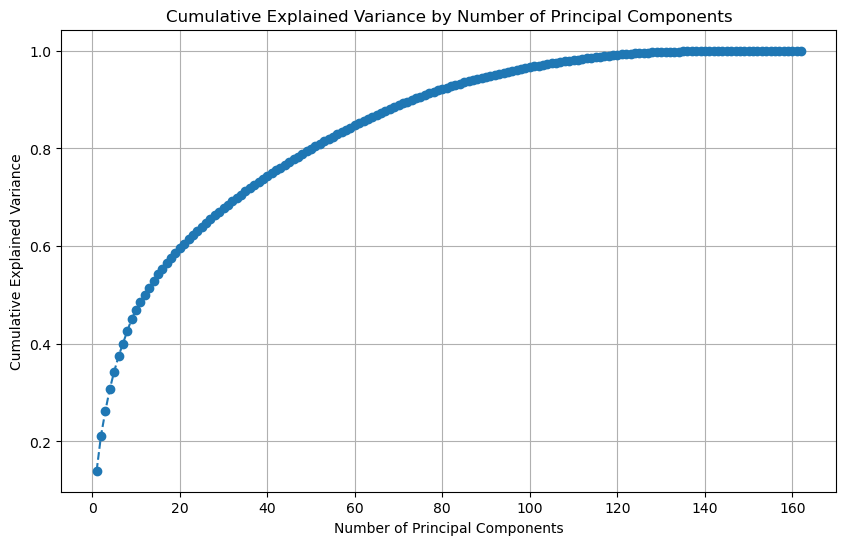

+--------------+------------------------+
|              |   Number of Components |
|--------------+------------------------|
| 80% Variance |                     51 |
| 90% Variance |                     74 |
| 95% Variance |                     92 |
| 99% Variance |                    119 |
+--------------+------------------------+

Cumulative Variance Explained by Each Number of Components:
+-----+------------------------+---------------------------------+
|     |   Number of Components |   Cumulative Variance Explained |
|-----+------------------------+---------------------------------|
|   0 |                      1 |                        0.140112 |
|   1 |                      2 |                        0.211918 |
|   2 |                      3 |                        0.262746 |
|   3 |                      4 |                        0.306951 |
|   4 |                      5 |                        0.342926 |
|   5 |                      6 |                        0.37403  |


In [47]:
## Define variour models to be built and evaluated along with their Hyper parameters
models = {
    "Logistic Regression": {
        "model": LogisticRegression(),
        "params": {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'solver': ['liblinear', 'lbfgs', 'saga'],
            'penalty': ['l2', 'none'],
            'max_iter': [100, 200, 500]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(),
        "params": {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': [5, 10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {'n_estimators': [50, 100], 'max_depth': [10, 20]}
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(),
        "params": {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.001, 0.01, 0.1, 0.5],
            'max_depth': [3, 5, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'subsample': [0.6, 0.8, 1.0]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(),
        "params": {
            'n_estimators': [50, 100, 500],
            'learning_rate': [0.001, 0.01, 0.1, 0.5],
            'algorithm': ['SAMME', 'SAMME.R']
        }
    },
    "XGBoost": {
        "model": XGBClassifier(),
        "params": {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.001, 0.01, 0.1, 0.3],
            'max_depth': [3, 5, 10, 20],
            'min_child_weight': [1, 3, 5],
            'gamma': [0, 0.1, 0.3, 0.5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }
    }
}


In [48]:
# Dictionary to store results
model_results = {}

In [49]:
## Generic method to train and evaluate the model 

def train_and_evaluate_model(model_name, model, param_grid, X_train, X_test, y_train, y_test, X_train_pca=None, X_test_pca=None):
    print(f"Training and evaluating {model_name}...")
    
    # Record the start time
    start_time = time.time()
    print(f"Start time for {model_name}: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))}")

    if model_name == "Gradient Boosting":
        model.set_params(verbose=1)
    if model_name == "XGBoost":
        model.set_params(n_jobs=-1, verbosity=1)
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train_pca, y_train)
    best_model = grid_search.best_estimator_
    
    # Evaluate the model
    accuracy, precision, recall, f1 = evaluate_model(best_model, X_train_pca, X_test_pca, y_train, y_test)
    
    # Record the end time
    end_time = time.time()
    print(f"End time for {model_name}: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))}")
    
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    print(f"{model_name} took {elapsed_time:.2f} seconds to train and evaluate.")
    
    return best_model, (accuracy, precision, recall, f1)

In [50]:
# Logistic Regression
lr_model, lr_metrics = train_and_evaluate_model(
    "Logistic Regression",
    models["Logistic Regression"]["model"],
    models["Logistic Regression"]["params"],
    X_train_res,
    X_test_scaled,
    y_train_res,
    y_test,
    X_train_pca=X_train_res_pca,
    X_test_pca=X_test_pca
)

Training and evaluating Logistic Regression...
Start time for Logistic Regression: 2024-08-21 12:00:08
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Accuracy: 0.8168
Precision: 0.3370
Recall: 0.8248
F1 Score: 0.4785
End time for Logistic Regression: 2024-08-21 12:01:56
Logistic Regression took 108.28 seconds to train and evaluate.


In [51]:
dt_model, dt_metrics = train_and_evaluate_model(
    "Decision Tree",
    models["Decision Tree"]["model"],
    models["Decision Tree"]["params"],
    X_train_res,
    X_test_scaled,
    y_train_res,
    y_test,
    X_train_pca=X_train_res_pca,
    X_test_pca=X_test_pca
)

Training and evaluating Decision Tree...
Start time for Decision Tree: 2024-08-21 12:01:56
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Accuracy: 0.8390
Precision: 0.3326
Recall: 0.5757
F1 Score: 0.4216
End time for Decision Tree: 2024-08-21 12:19:12
Decision Tree took 1035.47 seconds to train and evaluate.


In [52]:
# Random Forest
rf_model, rf_metrics = train_and_evaluate_model(
    "Random Forest",
    models["Random Forest"]["model"],
    models["Random Forest"]["params"],
    X_train_res,
    X_test_scaled,
    y_train_res,
    y_test,
    X_train_pca=X_train_res_pca,
    X_test_pca=X_test_pca
)

Training and evaluating Random Forest...
Start time for Random Forest: 2024-08-21 12:19:12
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Accuracy: 0.8983
Precision: 0.5009
Recall: 0.6187
F1 Score: 0.5536
End time for Random Forest: 2024-08-21 12:27:48
Random Forest took 515.85 seconds to train and evaluate.


In [53]:
# AdaBoost
ada_model, ada_metrics = train_and_evaluate_model(
    "AdaBoost",
    models["AdaBoost"]["model"],
    models["AdaBoost"]["params"],
    X_train_res,
    X_test_scaled,
    y_train_res,
    y_test,
    X_train_pca=X_train_res_pca,
    X_test_pca=X_test_pca
)

Training and evaluating AdaBoost...
Start time for AdaBoost: 2024-08-21 12:27:48
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Accuracy: 0.8447
Precision: 0.3749
Recall: 0.7850
F1 Score: 0.5075
End time for AdaBoost: 2024-08-21 14:31:07
AdaBoost took 7398.82 seconds to train and evaluate.


In [54]:
# XGBoost
xgb_model, xgb_metrics = train_and_evaluate_model(
    "XGBoost",
    models["XGBoost"]["model"],
    models["XGBoost"]["params"],
    X_train_res,
    X_test_scaled,
    y_train_res,
    y_test,
    X_train_pca=X_train_res_pca,
    X_test_pca=X_test_pca
)

Training and evaluating XGBoost...
Start time for XGBoost: 2024-08-21 14:31:07
Fitting 5 folds for each of 5184 candidates, totalling 25920 fits


KeyboardInterrupt: 

## 5. Model Evaluation and Selection

In [57]:
# Store the results in a dictionary
model_results = {
    'Logistic Regression': lr_metrics,
    'Decision Tree': dt_metrics,
    'Random Forest': rf_metrics,
    'AdaBoost': ada_metrics,
##    'XGBoost': xgb_metrics
}

In [58]:
def summarize_performance(model_results):
    # Convert the dictionary into a DataFrame for easier visualization
    summary_df = pd.DataFrame(model_results).T  # Transpose to have models as rows and metrics as columns
    summary_df.columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    
    print("Model Performance Summary:\n")
    print(summary_df)
    
    # Optionally, you can also plot the performance metrics for better visualization
    summary_df.plot(kind='bar', figsize=(12, 8))
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.show()
    
    # Calculate the average score for each model (you can adjust the weights if needed)
    summary_df['Average Score'] = summary_df.mean(axis=1)
    
    # Find the best-performing model
    best_model_name = summary_df['Average Score'].idxmax()
    best_model_score = summary_df['Average Score'].max()
    
    print(f"\nBest Performer: {best_model_name} with an Average Score of {best_model_score:.4f}")
    
    return best_model_name, summary_df


Model Performance Summary:

                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.816810   0.337025  0.824766  0.478514
Decision Tree        0.839048   0.332613  0.575701  0.421629
Random Forest        0.898333   0.500946  0.618692  0.553627
AdaBoost             0.844714   0.374916  0.785047  0.507476


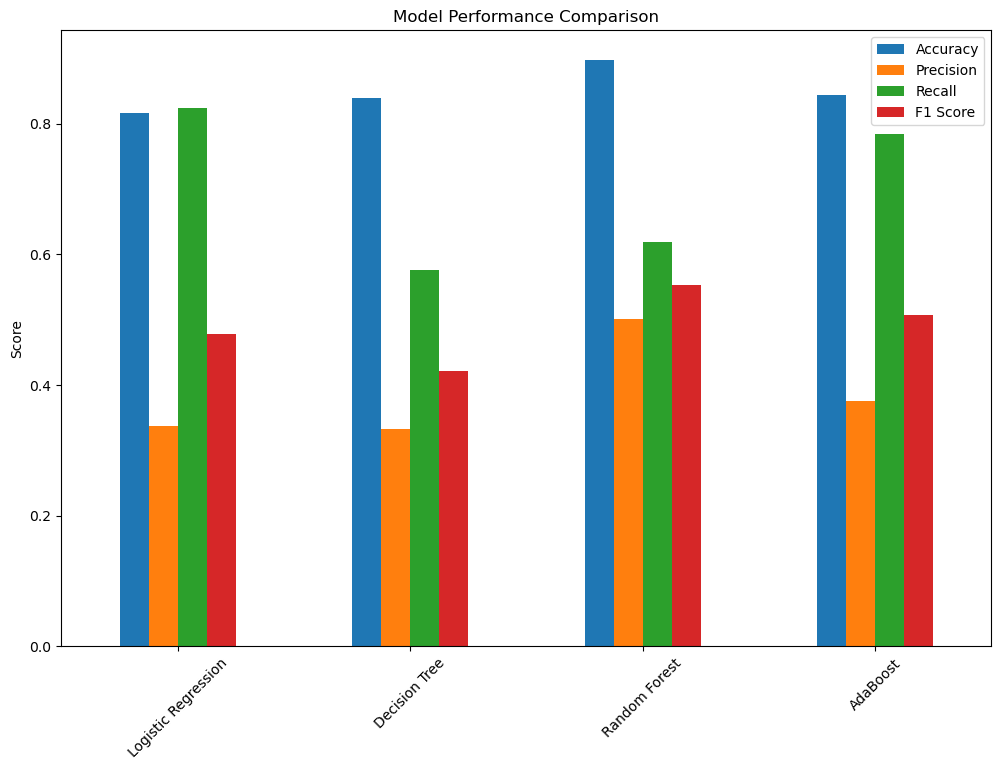


Best Performer: Random Forest with an Average Score of 0.6429


('Random Forest',
                      Accuracy  Precision    Recall  F1 Score  Average Score
 Logistic Regression  0.816810   0.337025  0.824766  0.478514       0.614279
 Decision Tree        0.839048   0.332613  0.575701  0.421629       0.542248
 Random Forest        0.898333   0.500946  0.618692  0.553627       0.642900
 AdaBoost             0.844714   0.374916  0.785047  0.507476       0.628038)

In [59]:
# Summarize the performance of each model
summarize_performance(model_results)

## 6. Model Validation

Applying all the data transformations on the test data that were applied on the train data

In [60]:
# Load the data
churn_data_test = pd.read_csv('test.csv')
churn_data_test.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.0,0.0,0.0,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5,5,4,103,90,60,50,30,30,6/21/2014,7/26/2014,8/24/2014,30,30,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,5,4,5,500,500,500,250,250,250,6/19/2014,7/16/2014,8/24/2014,250,0,0,NaN,NaN,Na

In [61]:
metadata_test = metadata_matrix(churn_data_test)
print(metadata_test)

                         Datatype  Non_Null_Count  Null_Count  \
arpu_3g_6                 float64            7585       22415   
count_rech_3g_6           float64            7585       22415   
fb_user_6                 float64            7585       22415   
night_pck_user_6          float64            7585       22415   
total_rech_data_6         float64            7585       22415   
max_rech_data_6           float64            7585       22415   
count_rech_2g_6           float64            7585       22415   
date_of_last_rech_data_6   object            7585       22415   
av_rech_amt_data_6        float64            7585       22415   
arpu_2g_6                 float64            7585       22415   
night_pck_user_7          float64            7706       22294   
arpu_2g_7                 float64            7706       22294   
fb_user_7                 float64            7706       22294   
arpu_3g_7                 float64            7706       22294   
count_rech_2g_7          

In [62]:
churn_data_test = churn_data_test.set_index('id')

In [64]:
# Dropping date columns
churn_data_test = churn_data_test.drop(date_cols, axis=1)

In [63]:
churn_data_test.drop(columns=columns_to_drop_unique, inplace=True)

In [65]:
# Converting all the above columns having <=33 unique values into categorical data type.
# Remove 'churn_probability' from the change_to_cat list if it's present
if 'churn_probability' in change_to_cat:
    change_to_cat.remove('churn_probability')

churn_data_test[change_to_cat]=churn_data_test[change_to_cat].astype('category')

In [66]:
# Finding & Grouping categories with less than 1% contribution in each column into "Others"
categorical = churn_data_test.dtypes == 'category'
categorical_vars = churn_data_test.columns[categorical].to_list()
ind_categorical_vars

for col in ind_categorical_vars : 
    category_counts = 100*churn_data_test[col].value_counts(normalize=True)
    print('\n',tabulate(pd.DataFrame(category_counts), headers='keys', tablefmt='psql'),'\n')
    low_count_categories = category_counts[category_counts <= 1].index.to_list()
    print(f"Replaced {low_count_categories} in {col} with category : Others")
    churn_data_test[col].replace(low_count_categories,'Others',inplace=True)


 +----+--------------------+
|    |   night_pck_user_7 |
|----+--------------------|
|  0 |           97.9367  |
|  1 |            2.06333 |
+----+--------------------+ 

Replaced [] in night_pck_user_7 with category : Others

 +----+----------------+
|    |   monthly_3g_6 |
|----+----------------|
|  0 |    94.3333     |
|  1 |     4.40667    |
|  2 |     0.886667   |
|  3 |     0.233333   |
|  5 |     0.06       |
|  4 |     0.0566667  |
|  6 |     0.00666667 |
| 11 |     0.00666667 |
|  7 |     0.00333333 |
|  8 |     0.00333333 |
| 14 |     0.00333333 |
+----+----------------+ 

Replaced [2, 3, 5, 4, 6, 11, 7, 8, 14] in monthly_3g_6 with category : Others

 +----+---------------+
|    |   sachet_3g_8 |
|----+---------------|
|  0 |   95.8333     |
|  1 |    2.71667    |
|  2 |    0.676667   |
|  3 |    0.276667   |
|  4 |    0.166667   |
|  5 |    0.0966667  |
|  6 |    0.07       |
|  7 |    0.0466667  |
|  8 |    0.0266667  |
|  9 |    0.0166667  |
| 12 |    0.0133333  |
| 14 | 

In [67]:
churn_data_test.drop(columns=columns_to_drop, inplace=True)

In [68]:
def find_ic_og_inconsistent_mou_rows(month):
    # Generate column names for the given month
    total_ic_mou_col = f'total_ic_mou_{month}'
    total_og_mou_col = f'total_og_mou_{month}'
    
    # Identify IC-related MOU columns for the given month (including additional fields)
    ic_mou_cols = [col for col in churn_data_test.columns if 
                   (col.startswith('loc_ic') or 
                    col.startswith('std_ic') or 
                    col.startswith('spl_ic') or 
                    col.startswith('isd_ic') or 
                    col.startswith('onnet_ic') or
                    col == f'ic_others_{month}' or 
                    col == f'roam_ic_mou_{month}' or
                    col == f'onnet_mou_{month}' or
                    col == f'offnet_mou_{month}') and col.endswith(f'_mou_{month}')]
    
    # Identify OG-related MOU columns for the given month (including additional fields)
    og_mou_cols = [col for col in churn_data_test.columns if 
                   (col.startswith('loc_og') or 
                    col.startswith('std_og') or 
                    col.startswith('spl_og') or 
                    col.startswith('isd_og') or 
                    col.startswith('onnet_og') or
                    col == f'og_others_{month}' or 
                    col == f'roam_og_mou_{month}' or
                    col == f'onnet_mou_{month}' or
                    col == f'offnet_mou_{month}') and col.endswith(f'_mou_{month}')]
    
    # Condition for IC inconsistency: total_ic_mou is not null, but any IC-related mou column is null
    ic_inconsistency_condition = churn_data_test[total_ic_mou_col].notnull() & churn_data_test[ic_mou_cols].isnull().any(axis=1)
    
    # Condition for OG inconsistency: total_og_mou is not null, but any OG-related mou column is null
    og_inconsistency_condition = churn_data_test[total_og_mou_col].notnull() & churn_data_test[og_mou_cols].isnull().any(axis=1)
    
    # Filter the DataFrame based on the conditions
    ic_inconsistent_rows = churn_data_test[ic_inconsistency_condition]
    og_inconsistent_rows = churn_data_test[og_inconsistency_condition]
    
    return ic_inconsistent_rows[ic_mou_cols + [total_ic_mou_col]], og_inconsistent_rows[og_mou_cols + [total_og_mou_col]]


def update_nulls_to_zero(month, ic_inconsistent_indices, og_inconsistent_indices):
    # Generate column names for the given month
    total_ic_mou_col = f'total_ic_mou_{month}'
    total_og_mou_col = f'total_og_mou_{month}'
    
    # Identify IC-related MOU columns for the given month (including additional fields)
    ic_mou_cols = [col for col in churn_data_test.columns if 
                   (col.startswith('loc_ic') or 
                    col.startswith('std_ic') or 
                    col.startswith('spl_ic') or 
                    col.startswith('isd_ic') or 
                    col.startswith('onnet_ic') or
                    col == f'ic_others_{month}' or 
                    col == f'roam_ic_mou_{month}' or
                    col == f'onnet_mou_{month}' or
                    col == f'offnet_mou_{month}') and col.endswith(f'_mou_{month}')]
    
    # Identify OG-related MOU columns for the given month (including additional fields)
    og_mou_cols = [col for col in churn_data_test.columns if 
                   (col.startswith('loc_og') or 
                    col.startswith('std_og') or 
                    col.startswith('spl_og') or 
                    col.startswith('isd_og') or 
                    col.startswith('onnet_og') or
                    col == f'og_others_{month}' or 
                    col == f'roam_og_mou_{month}' or
                    col == f'onnet_mou_{month}' or
                    col == f'offnet_mou_{month}') and col.endswith(f'_mou_{month}')]
    
    # Update IC-related nulls to 0, but only where the original column was null
    churn_data_test.loc[ic_inconsistent_indices, ic_mou_cols] = churn_data_test.loc[ic_inconsistent_indices, ic_mou_cols].fillna(0)
    
    # Update OG-related nulls to 0, but only where the original column was null
    churn_data_test.loc[og_inconsistent_indices, og_mou_cols] = churn_data_test.loc[og_inconsistent_indices, og_mou_cols].fillna(0)
    
    print(f"--- Month {month}: Updated null values to 0 for IC and OG MOU fields where inconsistencies were found. ---")

# Apply updates for each month
for month in ['6', '7', '8']:
    ic_inconsistent_rows, og_inconsistent_rows = find_ic_og_inconsistent_mou_rows(month)
    update_nulls_to_zero(month, ic_inconsistent_rows.index, og_inconsistent_rows.index)


def find_and_print_before_update(month):
    total_ic_mou_col = f'total_ic_mou_{month}'
    ic_others_col = f'ic_others_{month}'
    total_og_mou_col = f'total_og_mou_{month}'
    og_others_col = f'og_others_{month}'
    
    # Condition to identify rows where total IC is not null and ic_others is null
    ic_condition = churn_data_test[total_ic_mou_col].notnull() & churn_data_test[ic_others_col].isnull()
    og_condition = churn_data_test[total_og_mou_col].notnull() & churn_data_test[og_others_col].isnull()
    
    print(f"--- Month {month}: Rows before updating IC others to 0 ---")
    print(churn_data_test.loc[ic_condition, [total_ic_mou_col, ic_others_col]].head())
    
    print(f"--- Month {month}: Rows before updating OG others to 0 ---")
    print(churn_data_test.loc[og_condition, [total_og_mou_col, og_others_col]].head())
    
    return ic_condition, og_condition

# Apply this check for each month
for month in ['6', '7', '8']:
    ic_cond, og_cond = find_and_print_before_update(month)

    
def reapply_update_to_zero(month, ic_condition, og_condition):
    # Identify columns to update
    ic_others_col = f'ic_others_{month}'
    og_others_col = f'og_others_{month}'
    
    # Apply the update
    churn_data_test.loc[ic_condition, ic_others_col] = churn_data_test.loc[ic_condition, ic_others_col].fillna(0)
    churn_data_test.loc[og_condition, og_others_col] = churn_data_test.loc[og_condition, og_others_col].fillna(0)
    
    print(f"--- Month {month}: Reapplied update to zero for IC and OG others columns ---")

# Reapply the update and check the results
for month in ['6', '7', '8']:
    ic_cond, og_cond = find_and_print_before_update(month)  # Identify conditions
    reapply_update_to_zero(month, ic_cond, og_cond)          # Apply update

def verify_update(month):
    ic_others_col = f'ic_others_{month}'
    og_others_col = f'og_others_{month}'
    
    # Check if any NaNs remain after the update
    ic_nulls = churn_data_test[ic_others_col].isnull().sum()
    og_nulls = churn_data_test[og_others_col].isnull().sum()
    
    print(f"--- Month {month}: NaN count in IC others after update: {ic_nulls} ---")
    print(f"--- Month {month}: NaN count in OG others after update: {og_nulls} ---")

# Verify the update for each month
for month in ['6', '7', '8']:
    verify_update(month)



--- Month 6: Updated null values to 0 for IC and OG MOU fields where inconsistencies were found. ---
--- Month 7: Updated null values to 0 for IC and OG MOU fields where inconsistencies were found. ---
--- Month 8: Updated null values to 0 for IC and OG MOU fields where inconsistencies were found. ---
--- Month 6: Rows before updating IC others to 0 ---
       total_ic_mou_6  ic_others_6
id                                
70008             0.0          NaN
70011             0.0          NaN
70014             0.0          NaN
70028             0.0          NaN
70041             0.0          NaN
--- Month 6: Rows before updating OG others to 0 ---
       total_og_mou_6  og_others_6
id                                
70008             0.0          NaN
70011             0.0          NaN
70014             0.0          NaN
70028             0.0          NaN
70041             0.0          NaN
--- Month 7: Rows before updating IC others to 0 ---
       total_ic_mou_7  ic_others_7
id           

In [69]:
# Initialize the DataFrame to record outlier treatment
outlier_treatment_test = pd.DataFrame(columns=['Column', 'Outlier Threshold', 'Outliers replaced'])

# Iterate through each column with outliers
for col in columns_with_outliers:
    # Calculate the 99th percentile value
    outlier_threshold = churn_data_test[col].quantile(0.99)
    
    # Create a condition to identify outliers
    condition = churn_data_test[col] > outlier_threshold
    
    # Append the information about outliers to the DataFrame
    outlier_treatment_test = outlier_treatment_test.append({
        'Column': col,
        'Outlier Threshold': outlier_threshold,
        'Outliers replaced': churn_data_test.loc[condition, col].shape[0]
    }, ignore_index=True)
    
    # Cap the outliers
    churn_data_test.loc[condition, col] = outlier_threshold

# Display the DataFrame with outlier treatment details
print(outlier_treatment_test)


                 Column  Outlier Threshold Outliers replaced
0                arpu_6         1430.48978               300
1                arpu_7         1451.24503               300
2                arpu_8         1483.08727               300
3           onnet_mou_6         1358.32070               300
4           onnet_mou_7         1468.18610               300
5           onnet_mou_8         1463.38770               300
6          offnet_mou_6         1505.46940               300
7          offnet_mou_7         1539.69270               300
8          offnet_mou_8         1509.77130               300
9         roam_ic_mou_6          213.38600               300
10        roam_ic_mou_7          150.38300               300
11        roam_ic_mou_8          162.10370               300
12        roam_og_mou_6          269.79100               300
13        roam_og_mou_7          212.04150               300
14        roam_og_mou_8          235.33410               300
15     loc_og_t2t_mou_6 

In [70]:
churn_data_test.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.8, 0.85, 0.9])

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.0,30000.0,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,276.598312,273.357527,273.800891,118.571324,121.081334,118.741430,180.901347,181.026370,177.660114,7.140200,4.463348,4.843145,10.326884,6.951995,7.256720,39.814362,39.230021,38.269269,85.798633,85.063518,83.804288,3.134108,3.203256,3.073469,0.924557,1.104658,1.159962,133.221672,131.893279,129.499966,68.911511,73.147588,71.718288,74.699072,77.970221,75.107249,0.770477,0.747112,0.69784,149.727273,156.849190,153.583590,0.124780,0.135703,0.107024,3.251865,4.207717,4.206735,0.360814,0.0,0.0,293.186111,299.848712,294.148462,40.526620,40.694467,39.511641,98.836690,99.479806,98.061704,10.188396,10.793397,9.801958,154.881266,156.214549,152.265217,7.241660,7.608596,7.120243,16.748080,17.455440,16.898252,1.455768,1.498226,1.417634,27.444423,28.534383,27.270899,194.108855,198.003254,192.562677,0.057016,0.029737,0.036252,4.747534,5.337060,5.224499,0.406975,0.537828,0.494208,7.41460,7.559567,7.070567,318.587800,316.

In [71]:
# Total Voice Usage: Combine total incoming and outgoing minutes of usage
churn_data_test['total_voice_mou_6'] = churn_data_test['total_ic_mou_6'] + churn_data_test['total_og_mou_6']
churn_data_test['total_voice_mou_7'] = churn_data_test['total_ic_mou_7'] + churn_data_test['total_og_mou_7']
churn_data_test['total_voice_mou_8'] = churn_data_test['total_ic_mou_8'] + churn_data_test['total_og_mou_8']

# Total Internet Usage (combining 2G and 3G churn_data_test volumes)
churn_data_test['total_data_usage_6'] = churn_data_test['vol_2g_mb_6'] + churn_data_test['vol_3g_mb_6']
churn_data_test['total_data_usage_7'] = churn_data_test['vol_2g_mb_7'] + churn_data_test['vol_3g_mb_7']
churn_data_test['total_data_usage_8'] = churn_data_test['vol_2g_mb_8'] + churn_data_test['vol_3g_mb_8']

# Binary flags indicating whether the usage/value decreased
# For voice usage
churn_data_test['decreased_voice_mou_6_7'] = (churn_data_test['total_voice_mou_6'] > churn_data_test['total_voice_mou_7']).astype(int)
churn_data_test['decreased_voice_mou_7_8'] = (churn_data_test['total_voice_mou_7'] > churn_data_test['total_voice_mou_8']).astype(int)

# For internet usage
churn_data_test['decreased_data_usage_6_7'] = (churn_data_test['total_data_usage_6'] > churn_data_test['total_data_usage_7']).astype(int)
churn_data_test['decreased_data_usage_7_8'] = (churn_data_test['total_data_usage_7'] > churn_data_test['total_data_usage_8']).astype(int)

# For recharge amount
churn_data_test['decreased_rech_amt_6_7'] = (churn_data_test['total_rech_amt_6'] > churn_data_test['total_rech_amt_7']).astype(int)
churn_data_test['decreased_rech_amt_7_8'] = (churn_data_test['total_rech_amt_7'] > churn_data_test['total_rech_amt_8']).astype(int)

# For number of recharges
churn_data_test['decreased_rech_num_6_7'] = (churn_data_test['total_rech_num_6'] > churn_data_test['total_rech_num_7']).astype(int)
churn_data_test['decreased_rech_num_7_8'] = (churn_data_test['total_rech_num_7'] > churn_data_test['total_rech_num_8']).astype(int)

# For Volume based cost
churn_data_test['decreased_vbc_3g_6_7'] = (churn_data_test['jun_vbc_3g'] > churn_data_test['jul_vbc_3g']).astype(int)
churn_data_test['decreased_vbc_3g_7_8'] = (churn_data_test['jul_vbc_3g'] > churn_data_test['aug_vbc_3g']).astype(int)

# Display the newly created columns to verify
print(churn_data_test[['decreased_voice_mou_6_7', 'decreased_voice_mou_7_8',
            'decreased_data_usage_6_7', 'decreased_data_usage_7_8',
            'decreased_rech_amt_6_7', 'decreased_rech_amt_7_8',
            'decreased_rech_num_6_7', 'decreased_rech_num_7_8',
            'decreased_vbc_3g_6_7', 'decreased_vbc_3g_7_8']].head())


       decreased_voice_mou_6_7  decreased_voice_mou_7_8  \
id                                                        
69999                        1                        1   
70000                        0                        1   
70001                        0                        0   
70002                        0                        1   
70003                        0                        0   

       decreased_data_usage_6_7  decreased_data_usage_7_8  \
id                                                          
69999                         0                         0   
70000                         0                         0   
70001                         0                         0   
70002                         0                         0   
70003                         0                         0   

       decreased_rech_amt_6_7  decreased_rech_amt_7_8  decreased_rech_num_6_7  \
id                                                                           

In [72]:
churn_data_test.shape

(30000, 140)

In [73]:
# Convert categorical variables to dummy variables
categorical_cols_test = churn_data_test.select_dtypes(include=['object', 'category']).columns
X_test = pd.get_dummies(churn_data_test, columns=categorical_cols, drop_first=True)

# Ensure X_test has the same dummy variable columns as the training data
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
    
X_test = X_test[X_train.columns]

In [74]:
X_test_scaled = scaler.transform(X_test)


In [76]:
X_test_scaled.shape

(30000, 162)

In [77]:
desired_variance_threshold = 0.90

# Transform the test data using the fitted PCA
X_test_pca = pca.transform(X_test_scaled)

## 7. Final Model Testing


In [83]:
# Since Random forest gave the best Accuracy, we'll use that to predict on the test data.
# Unfortunatlely, I couldn't see the test results for XGBoost as the computation never finished. 
# I was hoping for a better accuracy there. Maybe my system didn't have the required computational power.

In [91]:
# Make predictions on the test data (which has been transformed by PCA) and create the DataFrame for predictions

# Since we haven't treated the test data for imbalance and we haven't deleted any row from test data, 
# the X_test_pca will have same order or records as the test.csv

# Create the DataFrame for predictions
predictions_df = pd.DataFrame({
    'id': churn_data_test.index,  # Using churn_data_test['id'] 
    'churn_probability': rf_model.predict(X_test_pca)
})

# Export to CSV
predictions_df.to_csv('predictions.csv', index=False)

In [93]:
##See the first few predictions
print("Predictions on Test Data:")
print(y_pred_test[:10])

Predictions on Test Data:
[0 0 0 0 0 1 0 0 0 0]


In [94]:
#Convert the predictions into a DataFrame
predictions_df = pd.DataFrame(y_pred_test, columns=['Predicted_Churn'])
print(predictions_df.head())

   Predicted_Churn
0                0
1                0
2                0
3                0
4                0
